## MVP Foot Traffic Trend Analysis for Restaurant Chain

#### by Burak BASOGUL

### Overview

**CLIENT:** A local restaurant chain operating in NYC. 

**ISSUE** : Client suspects that covid 19 pandemic conditions have drastically altered foot traffic volumes in some neighborhoods due to highly adapted rates of remote work option in the working population.  Client wants to identify foot traffic trends emerged during pandemic conditions and  monitor these trends as the covid 19 restrictions are gradually lifted and/or improved within the city. 

**GOAL** : Provide an initial study for the client identifying most significant trend shifts in volume of foot traffic from 2018 through the pandemic conditions to date in select NYC neighborhoods where some of the restaurant branches are located. 

**BENEFIT:** The initial report and subsequent monthly reports will then be included in decision making process by the Client  whether or not to move some of the branches into new neighborhoods or close them permanently.

**DATA / METHODOLOGY:** MTA provides web hosted weekly data of volumes of entry and exits recorded at turnstiles in text format. This data will be retrieved via SQLite and compiled using Pandas. Visual data will be provided using Matplotlib. Top five neighborhoods / stations with most drastic foot traffic volume changes will be identified and presented in the report.


In [1]:
import pandas as pd

In [2]:
import datetime

In [61]:
import numpy as np

In [3]:
chunksize = 1000000
df_19 = pd.concat([small_df for small_df in pd.read_csv("mta_data_19.csv",usecols=['C/A','UNIT',
                                                'SCP','STATION','DATE','TIME','DESC','EXITS'],
                                                infer_datetime_format=True, 
                                                parse_dates=[['DATE', 'TIME']],
                                                keep_date_col=True,
                                                chunksize=chunksize, 
                                                iterator=True)], ignore_index=True)


In [4]:
chunksize = 1000000
df_20 = pd.concat([small_df for small_df in pd.read_csv("mta_data_20.csv",usecols=['C/A','UNIT',
                                                'SCP','STATION','DATE','TIME','DESC','EXITS'],
                                                infer_datetime_format=True, 
                                                parse_dates=[['DATE', 'TIME']],
                                                keep_date_col=True,
                                                chunksize=chunksize, 
                                                iterator=True)], ignore_index=True)

In [5]:
chunksize = 1000000
df_21 = pd.concat([small_df for small_df in pd.read_csv("mta_data_21.csv",usecols=['C/A','UNIT',
                                                'SCP','STATION','DATE','TIME','DESC','EXITS'],
                                                infer_datetime_format=True, 
                                                parse_dates=[['DATE', 'TIME']],
                                                keep_date_col=True,
                                                chunksize=chunksize, 
                                                iterator=True)], ignore_index=True)

In [6]:
df_22 = pd.read_csv("mta_data_22.csv",usecols=['C/A','UNIT',
                                                'SCP','STATION','DATE','TIME','DESC','EXITS'],
                                                infer_datetime_format=True, 
                                                parse_dates=[['DATE', 'TIME']],
                                                keep_date_col=True)

In [7]:
# Sort values for 2019. 
df_19.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False, ignore_index=True)

In [8]:
#Find max Exit values registered at each turnstile on each day at each station.
turnstiles_daily_19 = (df_19
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.max())

In [9]:
turnstiles_daily_19[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_19
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_3237/908704577.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily_19[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_19


In [10]:
# Drop the rows for the earliest date in the df
turnstiles_daily_19.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [11]:
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        return 0
    return counter
turnstiles_daily_19["DAILY_EXITS"] = turnstiles_daily_19.apply(get_daily_counts, axis=1, max_counter=1000000)

In [12]:
# Sum of all Exit values from turnstiles grouped under C/A, Unit and Station
ca_unit_station_daily_19 = turnstiles_daily_19.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
ca_unit_station_daily_19.head()

,C/A,UNIT,STATION,DATE,DAILY_EXITS
0,A002,R051,59 ST,01/02/2019,7980.0
1,A002,R051,59 ST,01/03/2019,8159.0
2,A002,R051,59 ST,01/04/2019,8155.0
3,A002,R051,59 ST,01/05/2019,4563.0
4,A002,R051,59 ST,01/06/2019,3787.0


In [13]:
# Sum of all Exit values per Station per day.
station_daily_19 = turnstiles_daily_19.groupby(["STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
station_daily_19.head()

,STATION,DATE,DAILY_EXITS
0,1 AV,01/02/2019,21058.0
1,1 AV,01/03/2019,22531.0
2,1 AV,01/04/2019,23633.0
3,1 AV,01/05/2019,16661.0
4,1 AV,01/06/2019,13789.0


In [14]:
#Sum of all Exit values per Station in the year of 2018 sorted from highest.
station_totals_19 = station_daily_19.groupby('STATION').sum()\
    .sort_values('DAILY_EXITS', ascending=False)\
    .reset_index()

station_totals_19.head(10)

,STATION,DAILY_EXITS
0,34 ST-PENN STA,83112247.0
1,GRD CNTRL-42 ST,62909377.0
2,34 ST-HERALD SQ,58208773.0
3,FULTON ST,51636459.0
4,23 ST,46387406.0
5,TIMES SQ-42 ST,44470349.0
6,42 ST-PORT AUTH,42658003.0
7,14 ST-UNION SQ,40833981.0
8,CANAL ST,38531576.0
9,86 ST,38234873.0


In [15]:
total_exit_volume_19 = station_totals_19["DAILY_EXITS"].sum()
total_exit_volume_19

2650462774.0

In [16]:
# Sort values for 2020. 
df_20.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False, ignore_index=True)

In [17]:
#Find max Exit values registered at each turnstile on each day at each station.
turnstiles_daily_20 = (df_20
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.max())

In [18]:
turnstiles_daily_20[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_20
                                                .groupby(["C/A", "UNIT", "SCP", "STATION"])
                                                ["DATE", "EXITS"]
                                                .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_3237/28776503.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily_20[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_20


In [19]:
# Drop the rows for the earliest date in the df
turnstiles_daily_20.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [20]:
turnstiles_daily_20["DAILY_EXITS"] = turnstiles_daily_20.apply(
                                            get_daily_counts, axis=1, max_counter=1000000)

In [21]:
# Sum of all Exit values from turnstiles grouped under C/A, Unit and Station
ca_unit_station_daily_20 = turnstiles_daily_20.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
ca_unit_station_daily_20.head()

,C/A,UNIT,STATION,DATE,DAILY_EXITS
0,A002,R051,59 ST,01/02/2020,7737.0
1,A002,R051,59 ST,01/03/2020,7729.0
2,A002,R051,59 ST,01/04/2020,6508.0
3,A002,R051,59 ST,01/05/2020,5798.0
4,A002,R051,59 ST,01/06/2020,8756.0


In [22]:
# Sum of all Exit values per Station per day.
station_daily_20 = turnstiles_daily_20.groupby(["STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
station_daily_20.head()

,STATION,DATE,DAILY_EXITS
0,1 AV,01/02/2020,17949.0
1,1 AV,01/03/2020,18683.0
2,1 AV,01/04/2020,7771.0
3,1 AV,01/05/2020,6176.0
4,1 AV,01/06/2020,18893.0


In [23]:
#Sum of all Exit values per Station in the year of 2018 sorted from highest.
station_totals_20 = station_daily_20.groupby('STATION').sum()\
    .sort_values('DAILY_EXITS', ascending=False)\
    .reset_index()

station_totals_20.head(10)

,STATION,DAILY_EXITS
0,34 ST-PENN STA,34572311.0
1,34 ST-HERALD SQ,27105321.0
2,GRD CNTRL-42 ST,26326888.0
3,86 ST,23300762.0
4,14 ST-UNION SQ,22013665.0
5,FULTON ST,20943542.0
6,23 ST,20277729.0
7,TIMES SQ-42 ST,19913860.0
8,125 ST,19732888.0
9,42 ST-PORT AUTH,17347341.0


In [24]:
total_exit_volume_20 = station_totals_20["DAILY_EXITS"].sum()
total_exit_volume_20

1298267236.0

In [25]:
# Sort values for 2021. 
df_21.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False, ignore_index=True)

In [26]:
#Find max Exit values registered at each turnstile on each day at each station.
turnstiles_daily_21 = (df_21
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.max())

In [27]:
turnstiles_daily_21[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_21
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_3237/2560278915.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily_21[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_21


In [28]:
# Drop the rows for the earliest date in the df
turnstiles_daily_21.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [29]:
turnstiles_daily_21["DAILY_EXITS"] = turnstiles_daily_21.apply(get_daily_counts, axis=1, max_counter=1000000)

In [30]:
# Sum of all Exit values from turnstiles grouped under C/A, Unit and Station
ca_unit_station_daily_21 = turnstiles_daily_21.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
ca_unit_station_daily_21.head()

,C/A,UNIT,STATION,DATE,DAILY_EXITS
0,A002,R051,59 ST,01/02/2021,1975.0
1,A002,R051,59 ST,01/03/2021,1381.0
2,A002,R051,59 ST,01/04/2021,3420.0
3,A002,R051,59 ST,01/05/2021,3475.0
4,A002,R051,59 ST,01/06/2021,3575.0


In [31]:
# Sum of all Exit values per Station per day.
station_daily_21 = turnstiles_daily_21.groupby(["STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
station_daily_21.head()

,STATION,DATE,DAILY_EXITS
0,1 AV,01/02/2021,6054.0
1,1 AV,01/03/2021,4537.0
2,1 AV,01/04/2021,8145.0
3,1 AV,01/05/2021,8332.0
4,1 AV,01/06/2021,8532.0


In [32]:
#Sum of all Exit values per Station in the year of 2018 sorted from highest.
station_totals_21 = station_daily_21.groupby('STATION').sum()\
    .sort_values('DAILY_EXITS', ascending=False)\
    .reset_index()

station_totals_21.head(10)

,STATION,DAILY_EXITS
0,34 ST-PENN STA,41374891.0
1,34 ST-HERALD SQ,31018738.0
2,GRD CNTRL-42 ST,28092059.0
3,14 ST-UNION SQ,27331358.0
4,86 ST,26763640.0
5,125 ST,26014132.0
6,23 ST,24146234.0
7,42 ST-PORT AUTH,22903268.0
8,TIMES SQ-42 ST,22812458.0
9,FULTON ST,22097288.0


In [33]:
total_exit_volume_21 = station_totals_21["DAILY_EXITS"].sum()
total_exit_volume_21

1521192877.0

In [34]:
#Annual ridership drop in 2021 based on 2019 numbers
annual_21_ridership_drop = (total_exit_volume_19-total_exit_volume_21)/total_exit_volume_19
annual_21_ridership_drop

0.42606517928781895

In [35]:
# Sort values for 2022. 
df_22.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False, ignore_index=True)

In [36]:
df_22.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,DATE,TIME,DESC,EXITS
0,2022-03-04 20:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/04/2022,20:00:00,REGULAR,23
1,2022-03-04 16:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/04/2022,16:00:00,REGULAR,23
2,2022-03-04 12:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/04/2022,12:00:00,REGULAR,23
3,2022-03-04 08:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/04/2022,08:00:00,REGULAR,23
4,2022-03-04 04:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/04/2022,04:00:00,REGULAR,23


In [37]:
df_22.tail()

,DATE_TIME,C/A,UNIT,SCP,STATION,DATE,TIME,DESC,EXITS
2099587,2021-12-25 19:00:00,A002,R051,02-00-00,59 ST,12/25/2021,19:00:00,REGULAR,2647689
2099588,2021-12-25 15:00:00,A002,R051,02-00-00,59 ST,12/25/2021,15:00:00,REGULAR,2647662
2099589,2021-12-25 11:00:00,A002,R051,02-00-00,59 ST,12/25/2021,11:00:00,REGULAR,2647646
2099590,2021-12-25 07:00:00,A002,R051,02-00-00,59 ST,12/25/2021,07:00:00,REGULAR,2647627
2099591,2021-12-25 03:00:00,A002,R051,02-00-00,59 ST,12/25/2021,03:00:00,REGULAR,2647624


In [38]:
#Find max Exit values registered at each turnstile on each day at each station.
turnstiles_daily_22 = (df_22
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.max())

In [39]:
turnstiles_daily_22[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_22
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_3237/1583246923.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily_22[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_22


In [40]:
# Drop the rows for the earliest date in the df
turnstiles_daily_22.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [41]:
turnstiles_daily_22["DAILY_EXITS"] = turnstiles_daily_22.apply(get_daily_counts, axis=1, max_counter=1000000)

In [42]:
# Sum of all Exit values from turnstiles grouped under C/A, Unit and Station
ca_unit_station_daily_22 = turnstiles_daily_22.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
ca_unit_station_daily_22.head()

,C/A,UNIT,STATION,DATE,DAILY_EXITS
0,A002,R051,59 ST,01/02/2022,2071.0
1,A002,R051,59 ST,01/03/2022,4240.0
2,A002,R051,59 ST,01/04/2022,4404.0
3,A002,R051,59 ST,01/05/2022,4329.0
4,A002,R051,59 ST,01/06/2022,4478.0


In [43]:
# Sum of all Exit values per Station per day.
station_daily_22 = turnstiles_daily_22.groupby(["STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
station_daily_22.head()

,STATION,DATE,DAILY_EXITS
0,1 AV,01/02/2022,8874.0
1,1 AV,01/03/2022,12474.0
2,1 AV,01/04/2022,13450.0
3,1 AV,01/05/2022,13679.0
4,1 AV,01/06/2022,14687.0


In [44]:
station_daily_22.shape

(26043, 3)

In [45]:
#Sum of all Exit values per Station in the year of 2018 sorted from highest.
station_totals_22 = station_daily_22.groupby('STATION').sum()\
    .sort_values('DAILY_EXITS', ascending=False)\
    .reset_index()

station_totals_22.head(10)

,STATION,DAILY_EXITS
0,34 ST-PENN STA,8332849.0
1,GRD CNTRL-42 ST,7956749.0
2,34 ST-HERALD SQ,6424656.0
3,23 ST,6060645.0
4,86 ST,5864747.0
5,14 ST-UNION SQ,5500938.0
6,FULTON ST,5485793.0
7,42 ST-PORT AUTH,5250114.0
8,TIMES SQ-42 ST,5220188.0
9,59 ST COLUMBUS,5074345.0


In [46]:
top_10_stations_19 = station_totals_19["STATION"][0:10]
top_10_exits_19 = station_totals_19["DAILY_EXITS"][0:10]
top_10_stations_20 = station_totals_20["STATION"][0:10]
top_10_exits_20 = station_totals_20["DAILY_EXITS"][0:10]
top_10_stations_21 = station_totals_21["STATION"][0:10]
top_10_exits_21 = station_totals_21["DAILY_EXITS"][0:10]
top_10_stations_22 = station_totals_22["STATION"][0:10]
top_10_exits_22 = station_totals_22["DAILY_EXITS"][0:10]

In [47]:
import matplotlib.pyplot as plt

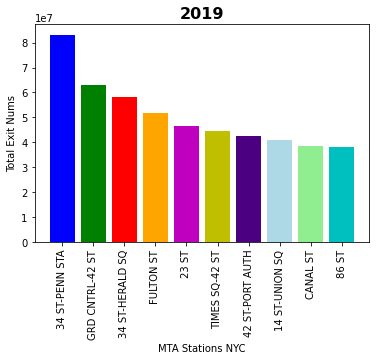

In [48]:
color_sch_1 = ['b','g','r','orange','m','y','indigo','lightblue','lightgreen','c']
plt.bar(top_10_stations_19,top_10_exits_19, color = color_sch_1)
plt.title("2019", fontsize = 16,weight='bold')
plt.xlabel('MTA Stations NYC')
plt.ylabel('Total Exit Nums')
plt.xticks(rotation=90)
plt.savefig('top_10_stations_19.jpg', bbox_inches = 'tight');

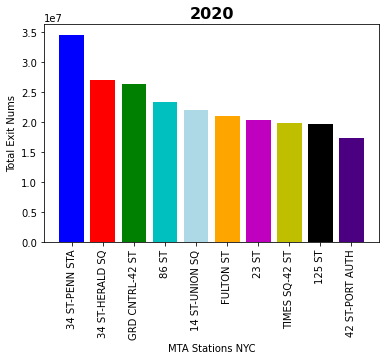

In [49]:
color_sch_2 = ['b','r','g','c','lightblue','orange','m','y','k','indigo']
plt.bar(top_10_stations_20,top_10_exits_20, color = color_sch_2 )
plt.title("2020", fontsize = 16,weight='bold')
plt.xlabel('MTA Stations NYC')
plt.ylabel('Total Exit Nums')
plt.xticks(rotation=90)
plt.savefig('top_10_stations_20.jpg', bbox_inches = 'tight');

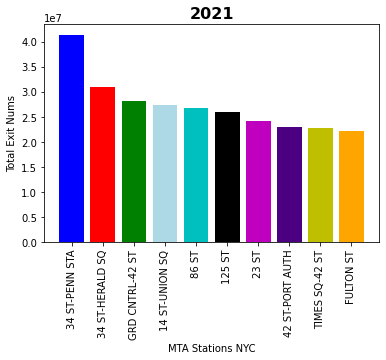

In [50]:
color_sch_3 = ['b','r','g','lightblue','c','k','m','indigo','y','orange']
plt.bar(top_10_stations_21,top_10_exits_21, color = color_sch_3)
plt.title("2021", fontsize = 16,weight='bold')
plt.xlabel('MTA Stations NYC')
plt.ylabel('Total Exit Nums')
plt.xticks(rotation=90)
plt.savefig('top_10_stations_21.jpg', bbox_inches = 'tight');

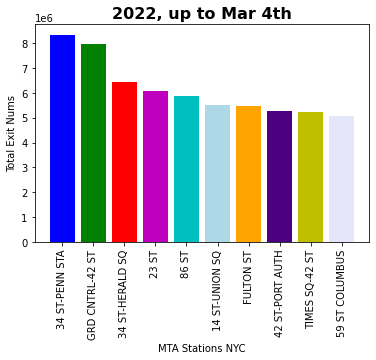

In [51]:
color_sch_4 = ['b','g','r','m','c','lightblue','orange','indigo','y','lavender']
plt.bar(top_10_stations_22,top_10_exits_22, color = color_sch_4)
plt.title("2022, up to Mar 4th", fontsize = 16,weight='bold')
plt.xlabel('MTA Stations NYC')
plt.ylabel('Total Exit Nums')
plt.xticks(rotation=90)
plt.savefig('top_10_stations_22.jpg', bbox_inches = 'tight');

## INITIAL OBSERVATIONS

* During pre-pandemic year of 2019, top 10 stations with the highest volumes of exit numbers are major hub stations that mostly serve commuters arriving from NJ, Brooklyn and 86th St Stations that serves Broadway, Central Park and major museums.

* During pandemic years of 2020 and 2021, prior top 10 stations show, up to 60% decline in exit numbers. However, 2021 shows improvements over 2020. First two months of exit numbers also show promise and might be an indicator of ridership levels bouncing back to somewhat normal levels.
* It seems least decline in exit levels occured in 125 St stations. The areas serving these stations might be an interest for the restaurant chain.

* Let's plot a timeseries for the top 10 Stations to better observe the changes year over year ridership.

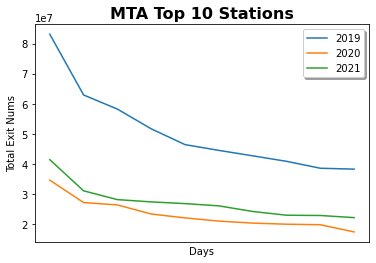

In [66]:
plt.plot(top_10_exits_19)
plt.plot(top_10_exits_20)
plt.plot(top_10_exits_21)
plt.title("MTA Top 10 Stations", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
plt.xlabel('Days')
plt.legend(['2019','2020','2021'],shadow = True, loc = 1)
plt.xticks([])
plt.savefig('MTA Annual Exit Data.jpg', bbox_inches = 'tight');

* After attempting to plot timeseries data for code manipulated below for 125 ST, it has become apparent that there is an error that is causing a significant anomaly in the exit data. We will need to investigate at a later time.

In [159]:
#Let's examine 125 St Station. 
#A quick look at New York City Subway shows that there are a total of four 125 St Stations.
# They are located on 1, (A,B,C,D), (2,3) and (4,5,6) lines. 
# We will create a mask to filter down to 125 St Station in data grouped by C/A, Unit and 
# Station.

mask_125= (ca_unit_station_daily_22["STATION"] == "125 ST")

ca_unit_station_daily_22_125ST = ca_unit_station_daily_22[mask_125].groupby(['C/A','UNIT']).STATION.count().reset_index()
ca_unit_station_daily_22_125ST.head(10)

,C/A,UNIT,STATION
0,N025,R102,69
1,N026,R102,69
2,R174,R034,69
3,R258,R132,69
4,R304,R206,69
5,R305,R206,69


* It appears there are four unique Unit ID's associated with four 125 ST Stations: R102, R034, R132 & R206. We will use these Unit ID's to filter down to each individual 125 ST Station to examine Daily Exit values over different time periods in an effort to establish any patterns that may be be useful in our recommendation to the restaurant chain.

In [160]:
#First let's take a look at annual data for four stations for pre-pandemic vs pandemic periods.

mask_R102_125_ST_19 = ((ca_unit_station_daily_19["UNIT"] == "R102") & 
                (ca_unit_station_daily_19["STATION"] == "125 ST"))

R102_125_ST_daily_19 = ca_unit_station_daily_19[mask_R102_125_ST_19]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
R102_125_ST_daily_19.head()

,UNIT,STATION,DATE,DAILY_EXITS
0,R102,125 ST,01/02/2019,20642.0
1,R102,125 ST,01/03/2019,21859.0
2,R102,125 ST,01/04/2019,22664.0
3,R102,125 ST,01/05/2019,16113.0
4,R102,125 ST,01/06/2019,15426.0


In [229]:
R102_125_ST_daily_19['DATE'] = pd.to_datetime(R102_125_ST_daily_19['DATE'])

In [161]:
#Similarly Daily Exit values  for years 2020, 2021 at Unit R102, Station 125 ST.

mask_R102_125_ST_20 = ((ca_unit_station_daily_20["UNIT"] == "R102") & 
                (ca_unit_station_daily_20["STATION"] == "125 ST"))

R102_125_ST_daily_20 = ca_unit_station_daily_20[mask_R102_125_ST_20]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

In [231]:
R102_125_ST_daily_20['DATE'] = pd.to_datetime(R102_125_ST_daily_20['DATE'])

In [162]:
mask_R102_125_ST_21 = ((ca_unit_station_daily_21["UNIT"] == "R102") & 
                (ca_unit_station_daily_21["STATION"] == "125 ST"))

R102_125_ST_daily_21 = ca_unit_station_daily_21[mask_R102_125_ST_21]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

In [232]:
R102_125_ST_daily_21['DATE'] = pd.to_datetime(R102_125_ST_daily_21['DATE'])

In [163]:
#For annual total numbers Unit R102 125 ST Station:
station_totals_R102_125_ST_19 = R102_125_ST_daily_19.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R102_125_ST_20 = R102_125_ST_daily_20.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R102_125_ST_21 = R102_125_ST_daily_21.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R102_125_ST = pd.concat([station_totals_R102_125_ST_19, station_totals_R102_125_ST_20, station_totals_R102_125_ST_21], ignore_index=True)

station_totals_R102_125_ST["YEAR"] = ['2019','2020','2021']

station_totals_R102_125_ST.set_index("YEAR", inplace = True)

station_totals_R102_125_ST.head()

,UNIT,STATION,DAILY_EXITS
YEAR,,,
2019,R102,125 ST,13692209.0
2020,R102,125 ST,7485702.0
2021,R102,125 ST,9358117.0


In [164]:
mask_R034_125_ST_19 = ((ca_unit_station_daily_19["UNIT"] == "R034") & 
                (ca_unit_station_daily_19["STATION"] == "125 ST"))

R034_125_ST_daily_19 = ca_unit_station_daily_19[mask_R034_125_ST_19]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
R034_125_ST_daily_19.head()

,UNIT,STATION,DATE,DAILY_EXITS
0,R034,125 ST,01/02/2019,6797.0
1,R034,125 ST,01/03/2019,7174.0
2,R034,125 ST,01/04/2019,7082.0
3,R034,125 ST,01/05/2019,5439.0
4,R034,125 ST,01/06/2019,5198.0


In [233]:
R034_125_ST_daily_19['DATE'] = pd.to_datetime(R034_125_ST_daily_19['DATE'])

In [165]:
#Similarly Daily Exit values  for years 2020, 2021 at Unit R034, Station 125 ST.

mask_R034_125_ST_20 = ((ca_unit_station_daily_20["UNIT"] == "R034") & 
                (ca_unit_station_daily_20["STATION"] == "125 ST"))

R034_125_ST_daily_20 = ca_unit_station_daily_20[mask_R034_125_ST_20]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

mask_R034_125_ST_21 = ((ca_unit_station_daily_21["UNIT"] == "R034") & 
                (ca_unit_station_daily_21["STATION"] == "125 ST"))

R034_125_ST_daily_21 = ca_unit_station_daily_21[mask_R034_125_ST_21]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()



In [234]:
R034_125_ST_daily_20['DATE'] = pd.to_datetime(R034_125_ST_daily_20['DATE'])
R034_125_ST_daily_21['DATE'] = pd.to_datetime(R034_125_ST_daily_21['DATE'])

In [166]:
station_totals_R034_125_ST_19 = R034_125_ST_daily_19.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R034_125_ST_20 = R034_125_ST_daily_20.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R034_125_ST_21 = R034_125_ST_daily_21.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R034_125_ST = pd.concat([station_totals_R034_125_ST_19, station_totals_R034_125_ST_20, station_totals_R034_125_ST_21], ignore_index=True)

station_totals_R034_125_ST["YEAR"] = ['2019','2020','2021']

station_totals_R034_125_ST.set_index("YEAR", inplace = True)

station_totals_R034_125_ST.head()

,UNIT,STATION,DAILY_EXITS
YEAR,,,
2019,R034,125 ST,4628056.0
2020,R034,125 ST,2264629.0
2021,R034,125 ST,2685557.0


*Annual Exit volumes are less than half of R102 at Unit R034.We will skip R034 and proceed to examining Unit R132.

In [167]:
mask_R132_125_ST_19 = ((ca_unit_station_daily_19["UNIT"] == "R132") & 
                (ca_unit_station_daily_19["STATION"] == "125 ST"))

R132_125_ST_daily_19 = ca_unit_station_daily_19[mask_R132_125_ST_19]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
R132_125_ST_daily_19.head()

,UNIT,STATION,DATE,DAILY_EXITS
0,R132,125 ST,01/02/2019,20137.0
1,R132,125 ST,01/03/2019,22376.0
2,R132,125 ST,01/04/2019,22834.0
3,R132,125 ST,01/05/2019,16718.0
4,R132,125 ST,01/06/2019,14714.0


In [235]:
R132_125_ST_daily_19['DATE'] = pd.to_datetime(R132_125_ST_daily_19['DATE'])

In [168]:
#Similarly Daily Exit values  for years 2020, 2021 at Unit R132, Station 125 ST.

mask_R132_125_ST_20 = ((ca_unit_station_daily_20["UNIT"] == "R132") & 
                (ca_unit_station_daily_20["STATION"] == "125 ST"))

R132_125_ST_daily_20 = ca_unit_station_daily_20[mask_R132_125_ST_20]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

mask_R132_125_ST_21 = ((ca_unit_station_daily_21["UNIT"] == "R132") & 
                (ca_unit_station_daily_21["STATION"] == "125 ST"))

R132_125_ST_daily_21 = ca_unit_station_daily_21[mask_R132_125_ST_21]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

In [236]:
R132_125_ST_daily_20['DATE'] = pd.to_datetime(R132_125_ST_daily_20['DATE'])
R132_125_ST_daily_21['DATE'] = pd.to_datetime(R132_125_ST_daily_21['DATE'])

In [169]:
station_totals_R132_125_ST_19 = R132_125_ST_daily_19.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R132_125_ST_20 = R132_125_ST_daily_20.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R132_125_ST_21 = R132_125_ST_daily_21.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R132_125_ST = pd.concat([station_totals_R132_125_ST_19, station_totals_R132_125_ST_20, station_totals_R132_125_ST_21], ignore_index=True)

station_totals_R132_125_ST["YEAR"] = ['2019','2020','2021']

station_totals_R132_125_ST.set_index("YEAR", inplace = True)

station_totals_R132_125_ST.head()

,UNIT,STATION,DAILY_EXITS
YEAR,,,
2019,R132,125 ST,12175759.0
2020,R132,125 ST,7553178.0
2021,R132,125 ST,9960115.0


* Annual Exit volumes at Unit R132 are comparable with Unit R102. We will note and proceed to examining Unit R206.

In [170]:
mask_R206_125_ST_19 = ((ca_unit_station_daily_19["UNIT"] == "R206") & 
                (ca_unit_station_daily_19["STATION"] == "125 ST"))

R206_125_ST_daily_19 = ca_unit_station_daily_19[mask_R206_125_ST_19]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()
R206_125_ST_daily_19.head()

,UNIT,STATION,DATE,DAILY_EXITS
0,R206,125 ST,01/02/2019,5557.0
1,R206,125 ST,01/03/2019,5946.0
2,R206,125 ST,01/04/2019,6283.0
3,R206,125 ST,01/05/2019,970.0
4,R206,125 ST,01/06/2019,70.0


In [237]:
R206_125_ST_daily_19['DATE'] = pd.to_datetime(R206_125_ST_daily_19['DATE'])

In [171]:
#Similarly Daily Exit values  for years 2020, 2021 at Unit R206, Station 125 ST.

mask_R206_125_ST_20 = ((ca_unit_station_daily_20["UNIT"] == "R206") & 
                (ca_unit_station_daily_20["STATION"] == "125 ST"))

R206_125_ST_daily_20 = ca_unit_station_daily_20[mask_R206_125_ST_20]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

mask_R206_125_ST_21 = ((ca_unit_station_daily_21["UNIT"] == "R206") & 
                (ca_unit_station_daily_21["STATION"] == "125 ST"))

R206_125_ST_daily_21 = ca_unit_station_daily_21[mask_R206_125_ST_21]\
                    .groupby(["UNIT","STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()

In [238]:
R206_125_ST_daily_20['DATE'] = pd.to_datetime(R206_125_ST_daily_20['DATE'])
R206_125_ST_daily_21['DATE'] = pd.to_datetime(R206_125_ST_daily_21['DATE'])

In [172]:
station_totals_R206_125_ST_19 = R206_125_ST_daily_19.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R206_125_ST_20 = R206_125_ST_daily_20.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R206_125_ST_21 = R206_125_ST_daily_21.groupby(['UNIT','STATION']).sum()\
                                .sort_values('DAILY_EXITS', ascending=False)\
                                .reset_index()

station_totals_R206_125_ST = pd.concat([station_totals_R206_125_ST_19, station_totals_R206_125_ST_20, station_totals_R206_125_ST_21], ignore_index=True)

station_totals_R206_125_ST["YEAR"] = ['2019','2020','2021']

station_totals_R206_125_ST.set_index("YEAR", inplace = True)

station_totals_R206_125_ST.head()

,UNIT,STATION,DAILY_EXITS
YEAR,,,
2019,R206,125 ST,3970911.0
2020,R206,125 ST,2429379.0
2021,R206,125 ST,4010343.0


*Annual Exit volumes of Unit R206 are less than 1/3 of Unit R102 vs R132. We will now focus on Unit R102 and R132 to determine trip patterns if we can.

In [173]:
import numpy as np

In [240]:
R102_125_ST_daily_19.dtypes

UNIT                   object
STATION                object
DATE           datetime64[ns]
DAILY_EXITS           float64
dtype: object

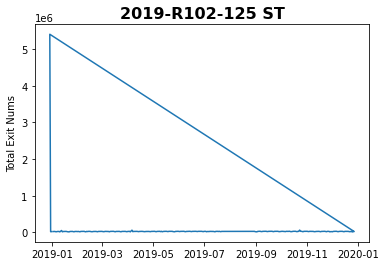

In [241]:
plt.plot(R102_125_ST_daily_19.DATE,R102_125_ST_daily_19.DAILY_EXITS)
plt.title("2019-R102-125 ST", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
ticks_x = np.linspace(0, 364, 12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.savefig('(R102_125_ST_daily_19.jpg', bbox_inches = 'tight');

* It appears there is an error in the data compiled for 125 ST, so will abort this attempt for now and focus on plotting a time series for the top 10 stations.

In [175]:
R102_125_ST_daily_19_median = np.median(R102_125_ST_daily_19["DAILY_EXITS"], axis=0)
R102_125_ST_daily_19_median

24085.0

In [176]:
R102_125_ST_annual_19_total = R102_125_ST_daily_19["DAILY_EXITS"].sum()
R102_125_ST_annual_19_total

13692209.0

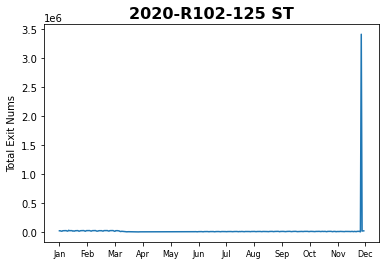

In [177]:
plt.plot(R102_125_ST_daily_20["DATE"],R102_125_ST_daily_20["DAILY_EXITS"])
plt.title("2020-R102-125 ST", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
ticks_x = np.linspace(0, 364, 12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x, months, fontsize = '8')
plt.savefig('(R102_125_ST_daily_20.jpg', bbox_inches = 'tight');

In [178]:
R102_125_ST_daily_20_median = np.median(R102_125_ST_daily_20["DAILY_EXITS"], axis=0)
R102_125_ST_daily_20_median

9724.0

In [179]:
R102_125_ST_annual_20_total = R102_125_ST_daily_20["DAILY_EXITS"].sum()
R102_125_ST_annual_20_total

7485702.0

In [180]:
R102_125_ST_annual_20_ridership_drop= (R102_125_ST_annual_19_total-R102_125_ST_annual_20_total)/R102_125_ST_annual_19_total
R102_125_ST_annual_20_ridership_drop

0.4532874863362077

In [181]:
R102_125_ST_median_20_ridership_drop= (R102_125_ST_daily_19_median - R102_125_ST_daily_20_median)/R102_125_ST_daily_19_median
R102_125_ST_median_20_ridership_drop

0.5962632343782437

* The outlier data for holiday travel spike masks the median drop. (45% annual drop in total ridership vs 60% annual drop in median daily exit numbers. Let's check 2021 vs 2019 to validate.

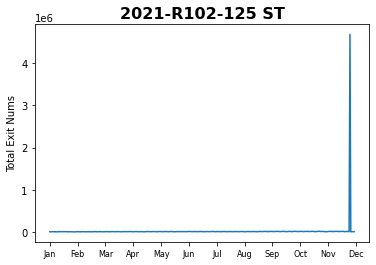

In [182]:
plt.plot(R102_125_ST_daily_21["DATE"],R102_125_ST_daily_21["DAILY_EXITS"])
plt.title("2021-R102-125 ST", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
ticks_x = np.linspace(0, 364, 12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x, months, fontsize = '8')
plt.savefig('(R102_125_ST_daily_21.jpg', bbox_inches = 'tight');

In [183]:
R102_125_ST_daily_21_median = np.median(R102_125_ST_daily_21["DAILY_EXITS"], axis=0)
R102_125_ST_daily_21_median

13025.0

In [184]:
R102_125_ST_annual_21_total = R102_125_ST_daily_21["DAILY_EXITS"].sum()
R102_125_ST_annual_21_total

9358117.0

In [185]:
R102_125_ST_annual_21_ridership_drop= (R102_125_ST_annual_19_total-R102_125_ST_annual_21_total)/R102_125_ST_annual_19_total
R102_125_ST_annual_21_ridership_drop

0.31653709054543355

In [186]:
R102_125_ST_median_21_ridership_drop= (R102_125_ST_daily_19_median - R102_125_ST_daily_21_median)/R102_125_ST_daily_19_median
R102_125_ST_median_20_ridership_drop

0.5962632343782437

* For 2021 recovering holiday travel numbers further mask the drop in median daily exit numbers. Let's move onto Unit R132.

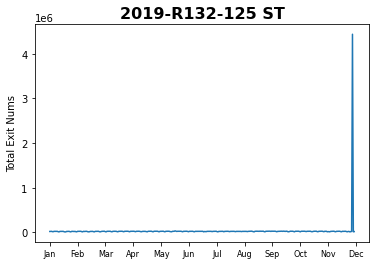

In [187]:
plt.plot(R132_125_ST_daily_19["DATE"],R132_125_ST_daily_19["DAILY_EXITS"])
plt.title("2019-R132-125 ST", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
ticks_x = np.linspace(0, 364, 12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x, months, fontsize = '8')
plt.savefig('(R132_125_ST_daily_19.jpg', bbox_inches = 'tight');

In [188]:
R132_125_ST_daily_19_median = np.median(R132_125_ST_daily_19["DAILY_EXITS"], axis=0)
R132_125_ST_daily_19_median

22981.0

In [189]:
R132_125_ST_annual_19_total = R132_125_ST_daily_19["DAILY_EXITS"].sum()
R132_125_ST_annual_19_total

12175759.0

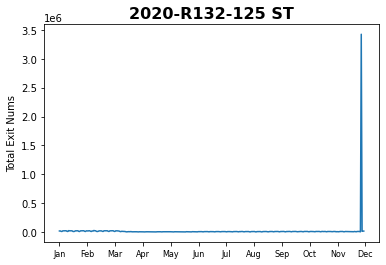

In [190]:
plt.plot(R132_125_ST_daily_20["DATE"],R132_125_ST_daily_20["DAILY_EXITS"])
plt.title("2020-R132-125 ST", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
ticks_x = np.linspace(0, 364, 12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x, months, fontsize = '8')
plt.savefig('(R132_125_ST_daily_20.jpg', bbox_inches = 'tight');

In [191]:
R132_125_ST_daily_20_median = np.median(R132_125_ST_daily_20["DAILY_EXITS"], axis=0)
R132_125_ST_daily_20_median

10340.0

In [192]:
R132_125_ST_annual_20_total = R132_125_ST_daily_20["DAILY_EXITS"].sum()
R132_125_ST_annual_20_total

7553178.0

In [193]:
R132_125_ST_annual_20_ridership_drop= (R132_125_ST_annual_19_total-R132_125_ST_annual_20_total)/R132_125_ST_annual_19_total
R132_125_ST_annual_20_ridership_drop

0.37965444289756395

In [194]:
R132_125_ST_median_20_ridership_drop= (R132_125_ST_daily_19_median - R132_125_ST_daily_20_median)/R132_125_ST_daily_19_median
R132_125_ST_median_20_ridership_drop

0.5500630956007136

* Similar to Unit R102, we also observe a higher level of drop in the median daily exit numbers vs the total annual exit numbers (55% vs 38%) Let's examine year 2021 to conclude.

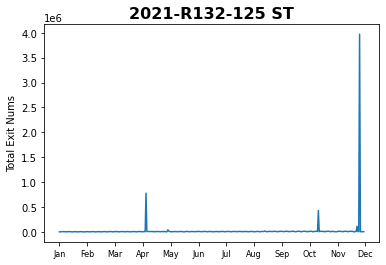

In [195]:
plt.plot(R132_125_ST_daily_21["DATE"],R132_125_ST_daily_21["DAILY_EXITS"])
plt.title("2021-R132-125 ST", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
ticks_x = np.linspace(0, 364, 12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x, months, fontsize = '8')
plt.savefig('(R132_125_ST_daily_21.jpg', bbox_inches = 'tight');

In [196]:
R132_125_ST_daily_21_median = np.median(R132_125_ST_daily_21["DAILY_EXITS"], axis=0)
R132_125_ST_daily_21_median

13206.0

In [197]:
R132_125_ST_annual_21_total = R132_125_ST_daily_21["DAILY_EXITS"].sum()
R132_125_ST_annual_21_total

9960115.0

In [198]:
R132_125_ST_annual_21_ridership_drop= (R132_125_ST_annual_19_total-R132_125_ST_annual_21_total)/R132_125_ST_annual_19_total
R132_125_ST_annual_21_ridership_drop

0.1819717358071887

In [199]:
R132_125_ST_median_21_ridership_drop= (R132_125_ST_daily_19_median - R132_125_ST_daily_21_median)/R132_125_ST_daily_19_median
R132_125_ST_median_21_ridership_drop

0.4253513772246639

* For Unit R132 in 2021, the total annual rideship numbers continue to improve and get closer to the 2019 levels but this increase appears to be spurred by hikes in daily exit numbers in April, Oct and Holiday Season. A 42% drop in median daily ridership is observed vs 2019 which fits with data for the overall drop in ridership in the entire MTA system.

* Now, let's examine available ridership data from 2022 vs 2019 in an effort to see if recovery in ridership levels continue to trend upwards.

In [200]:
station_daily_19['DATE'] = pd.to_datetime(station_daily_19['DATE'])

In [201]:
#Filter into Daily Exit Numbers per Station from 2019 up to Mar 4th which is the last date of data 
#available for 2022.
station_daily_19_new = station_daily_19[(station_daily_19['DATE'] >= '12/25/2018')&(station_daily_19['DATE'] <= '03/04/2019')]
station_daily_19_new


,STATION,DATE,DAILY_EXITS
0,1 AV,2019-01-02,21058.0
1,1 AV,2019-01-03,22531.0
2,1 AV,2019-01-04,23633.0
3,1 AV,2019-01-05,16661.0
4,1 AV,2019-01-06,13789.0
...,...,...,...
136651,ZEREGA AV,2019-03-03,1068.0
136652,ZEREGA AV,2019-03-04,1756.0
136951,ZEREGA AV,2018-12-29,743395.0
136952,ZEREGA AV,2018-12-30,1197.0


In [202]:
station_daily_22['DATE'] = pd.to_datetime(station_daily_22['DATE'])

In [203]:
station_daily_19_new_total = station_daily_19_new["DAILY_EXITS"].sum()
station_daily_19_new_total

1302099970.0

In [204]:
station_daily_22_total = station_daily_22["DAILY_EXITS"].sum()
station_daily_22_total

330166632.0

* Ridership is about 75% down on 2019 levels in 2022 compared between same periods from late Dec to early Mar.

* Let's plot this data to visualize the difference over the same period of time.

In [212]:
# Daily exit number totals across the entire MTA system
station_daily_19_all = turnstiles_daily_19.groupby("DATE")[['DAILY_EXITS']].sum().reset_index()
station_daily_19_all

,DATE,DAILY_EXITS
0,01/02/2019,4.117057e+06
1,01/03/2019,4.365957e+06
2,01/04/2019,4.392810e+06
3,01/05/2019,2.884997e+06
4,01/06/2019,3.652789e+06
...,...,...
358,12/26/2019,3.375193e+06
359,12/27/2019,4.102773e+06
360,12/29/2018,1.039566e+09
361,12/30/2018,3.357865e+06


In [214]:
station_daily_19_all['DATE'] = pd.to_datetime(station_daily_19_all['DATE'])

In [213]:
station_daily_22_all = turnstiles_daily_22.groupby("DATE")[['DAILY_EXITS']].sum().reset_index()
station_daily_22_all

,DATE,DAILY_EXITS
0,01/02/2022,1293801.0
1,01/03/2022,2274841.0
2,01/04/2022,2244263.0
3,01/05/2022,2210776.0
4,01/06/2022,2284719.0
...,...,...
64,12/27/2021,2008322.0
65,12/28/2021,2204474.0
66,12/29/2021,2144630.0
67,12/30/2021,2398315.0


In [216]:
station_daily_19_all_subset = station_daily_19_all[(station_daily_19_all['DATE'] >= '12/25/2018')&(station_daily_19_all['DATE'] <= '03/08/2019')]
station_daily_19_all_subset

,DATE,DAILY_EXITS
0,2019-01-02,4.117057e+06
1,2019-01-03,4.365957e+06
2,2019-01-04,4.392810e+06
3,2019-01-05,2.884997e+06
4,2019-01-06,3.652789e+06
...,...,...
64,2019-03-07,4.844232e+06
65,2019-03-08,5.042064e+06
360,2018-12-29,1.039566e+09
361,2018-12-30,3.357865e+06


In [225]:
plt.plot(station_daily_19_all_subset["DATE"],station_daily_19_all_subset["DAILY_EXITS"])
plt.title("2019 Partial Exit Data", fontsize = 16,weight='bold')
plt.ylabel('Total Exit Nums')
ticks_x1 = np.linspace(0, 6, 10)
weeks = ['12/25','01/01','01/08','01/15','01/22','01/29','02/05','02/12','02/19','02/26']
plt.xticks(ticks_x1, weeks, fontsize = '8', rotation = 90)
plt.savefig('2019 Partial Exit Data.jpg', bbox_inches = 'tight');

SyntaxError: positional argument follows keyword argument (974946248.py, line 6)

## CONCLUSION

* Even though the initial total annual exit numbers at four 125 ST stations appeared to indicate a far less drop in ridership, it is clear that the source of the smaller decrease in overall rideship levels is the spontaneous  spike in ridership levels during Holidays. 

* The fact that all 125 ST stations are on lines that are intersecting the bus line to the LaGuardia Airport explains the spontaneous spikes in ridership levels during Holidays.



## RECOMMEDATIONS


* Even though initial total ridership volumes indicated to a lesser drop at 125 ST Stations vs the top 10 performing stations in 2019, the median daily ridership numbers indicate that the drop in ridership levels is comparable to other stations in the MTA system. This study does not point to a weighted shift in ridership levels at one or more stations as anticapated originally.

* However, with new remote work policies put in place in several work sectors, it is recommended that quarterly reports to monitor ridership levels at areas of interest to the management be preapared to identify any possible shifts and/or changes in 2022 as the pandemic restrictions are lifted or improved.